# News Classifier using BERT

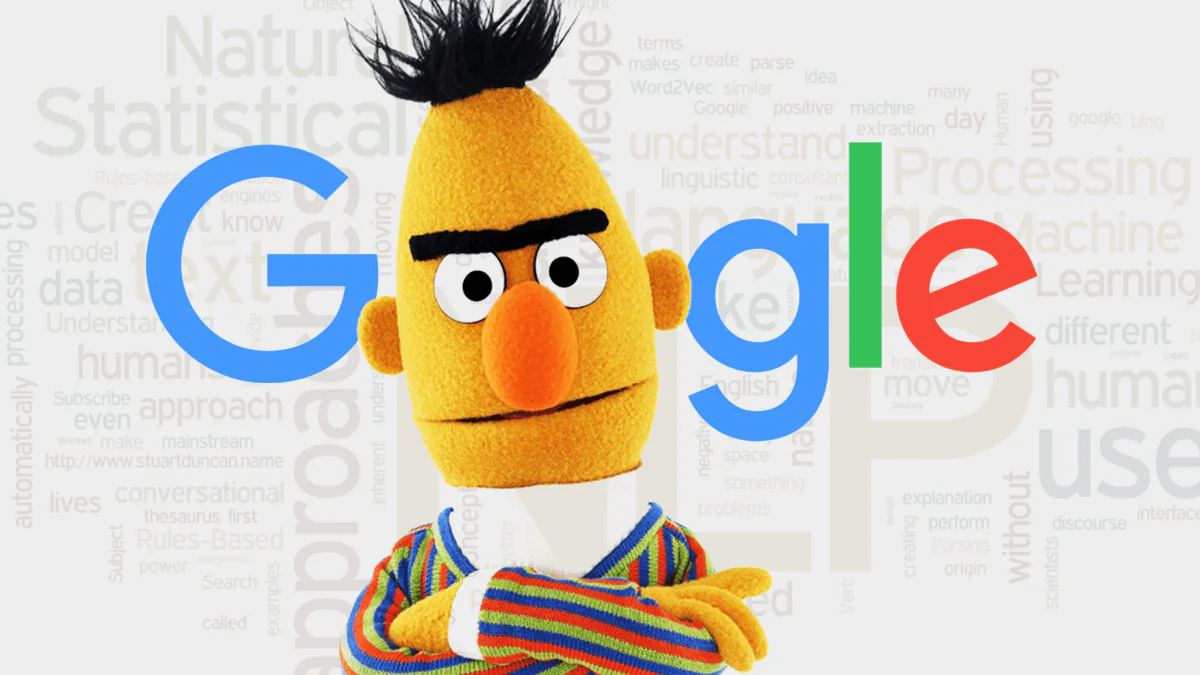

In [5]:
import requests
import json
import pandas as pd

url = 'https://raw.githubusercontent.com/CJTAYL/news_class/main/data/news_category_trainingdata.json'

response = requests.get(url)

if response.status_code == 200:
    # Split the text into lines and parse each line individually
    lines = response.text.splitlines()
    data = [json.loads(line) for line in lines]

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)

    print(df.head())
else:
    print(f"Failed to retrieve data: {response.status_code}")

        category                                           headline  \
0          CRIME  There Were 2 Mass Shootings In Texas Last Week...   
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   
2  ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   
3  ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   
4  ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   

           authors                                               link  \
0  Melissa Jeltsen  https://www.huffingtonpost.com/entry/texas-ama...   
1    Andy McDonald  https://www.huffingtonpost.com/entry/will-smit...   
2       Ron Dicker  https://www.huffingtonpost.com/entry/hugh-gran...   
3       Ron Dicker  https://www.huffingtonpost.com/entry/jim-carre...   
4       Ron Dicker  https://www.huffingtonpost.com/entry/julianna-...   

                                   short_description        date  
0  She left her husband. He killed their children...  2018-05-26  


In [6]:
# Combining headline and text description into new category of text
df['text'] = df['headline'] + ' ' + df['short_description']

In [7]:
# Value counts for each category of news
df['category'].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [8]:
import numpy as np

# Creating binary classes, where 1 = healthy living or wellness and else = 0
df['target'] = np.where((np.logical_or(df['category']=='WELLNESS', df['category']=='HEALTHY LIVING')), 1, 0)


In [9]:
df.head()

,category,headline,authors,link,short_description,date,text,target
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0


In [10]:
# Dropping unnecessary categories
df_simple = df.drop(['category', 'headline', 'authors', 'link', 'short_description', 'date'], axis=1)

In [11]:
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

max_length = 256
batch_size = 16

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=max_length)

# Split data into train and temp sets
train_data, temp_data, train_labels, temp_labels = train_test_split(df_simple['text'], df_simple['target'], test_size=0.4, random_state=24)

# Split the temp data into validation and test sets
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=24)

train_encodings = tokenize_function({'text': train_data.tolist()})
val_encodings = tokenize_function({'text': val_data.tolist()})
test_encodings = tokenize_function({'text': test_data.tolist()})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the dataset
train_dataset = TextDataset(train_encodings, train_labels.tolist())
val_dataset = TextDataset(val_encodings, val_labels.tolist())
test_dataset = TextDataset(test_encodings, test_labels.tolist())


In [13]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [14]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
!pip install accelerate -U

In [16]:
!pip install transformers[torch]

In [17]:
import torch
import accelerate
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # Output directory
    num_train_epochs=3,              # Total number of training epochs
    per_device_train_batch_size=batch_size,  # Batch size per device during training
    per_device_eval_batch_size=batch_size,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
10,0.704300
20,0.665800
30,0.570000
40,0.485400
50,0.457000
60,0.436700
70,0.327400
80,0.340700
90,0.286900
100,0.388300


TrainOutput(global_step=22596, training_loss=0.15276561910509112, metrics={'train_runtime': 15533.4017, 'train_samples_per_second': 23.275, 'train_steps_per_second': 1.455, 'total_flos': 4.756166458873344e+16, 'train_loss': 0.15276561910509112, 'epoch': 3.0})

In [18]:
# Evaluate the model
trainer.evaluate()


{'eval_loss': 0.19017575681209564,
 'eval_runtime': 558.7891,
 'eval_samples_per_second': 71.889,
 'eval_steps_per_second': 4.494,
 'epoch': 3.0}

In [19]:
# Make predictions on the test set
predictions = trainer.predict(test_dataset)

In [20]:
from scipy.special import softmax
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Get the raw predictions and true labels from the predict output
raw_predictions = predictions.predictions
true_labels = predictions.label_ids

# Apply softmax to convert logits to probabilities
prob_predictions = softmax(raw_predictions, axis=1)

# Get the predicted labels
predicted_labels = np.argmax(prob_predictions, axis=1)

# Compute metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.9472256105150482
Precision: 0.944941042462972
Recall: 0.9472256105150482
F1 Score: 0.9454516798502101


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# Save the model
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_save_path = '/content/drive/MyDrive/BERT_Model'
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

('/content/drive/MyDrive/BERT_Model/tokenizer_config.json',
 '/content/drive/MyDrive/BERT_Model/special_tokens_map.json',
 '/content/drive/MyDrive/BERT_Model/vocab.txt',
 '/content/drive/MyDrive/BERT_Model/added_tokens.json')